In [1]:
print("hi")

hi


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mnist_gan

In [3]:
GENERATOR_FILE = 'generator.pt'

In [4]:
generator = mnist_gan.Generator(code_size=100)
generator.load_state_dict(torch.load(GENERATOR_FILE, map_location=torch.device('cpu')))
generator.eval()

Generator(
  (dense): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (main): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [5]:
# Since the latent space is not 2D, the best we can do is a slice of it
X = torch.randn(1, generator.code_size)
Y = torch.randn(1, generator.code_size)

In [6]:
def generate_from_1D(alpha):
    return generator((X*alpha + Y*(1.-alpha)))[0, 0].detach().numpy().clip(-1, 1)

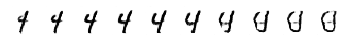

In [7]:
cols = 10
fig, axes = plt.subplots(ncols=cols)
for col_idx, ax in enumerate(axes):
    image = generate_from_1D((col_idx/(cols-1)))
    ax.imshow(image, cmap="gray_r", interpolation="none")
    ax.set_axis_off()

In [8]:
test_random_generator = np.random.RandomState(42)

In [9]:
test_input = test_random_generator.normal(size=(5, generator.code_size)).astype(np.float32)
np.savetxt("test_input.dat", test_input)

In [10]:
generated_images = generator(torch.from_numpy(test_input)).detach().numpy()
for index, image in enumerate(generated_images):
    np.savetxt(f"test_output_{index}.dat", image[0])

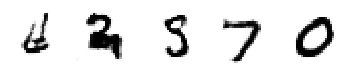

In [11]:
fig, axes = plt.subplots(ncols=len(generated_images))
for ax, image in zip(axes, generated_images):
    ax.imshow(image[0], cmap="gray_r", interpolation="none")
    ax.set_axis_off()

In [12]:
ONNX_FILE = "MNIST_generator.onnx"
torch.onnx.export(generator, X, ONNX_FILE, output_names=["generated_image"])

In [13]:
import onnx
onnx_model = onnx.load(ONNX_FILE)

In [14]:
from onnx_tf.backend import prepare
TF_PB_FILE = "MNIST_generator.pb"
tf_rep = prepare(onnx_model)
tf_rep.export_graph(TF_PB_FILE)

/mnt/nkazeev/onnx-tensorflow/onnx_tf/common/__init__.py:96: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)
2020-06-19 16:42:15,127 - onnx-tf - INFO - Fail to get since_version of BitShift in domain `` with max_inclusive_version=9. Set to 1.
2020-06-19 16:42:15,129 - onnx-tf - INFO - Unknown op ConstantFill in domain `ai.onnx`.
2020-06-19 16:42:15,130 - onnx-tf - INFO - Fail to get since_version of ConvInteger in domain `` with max_inclusive_version=9. Set to 1.
2020-06-19 16:42:15,130 - onnx-tf - INFO - Fail to get since_version of CumSum in domain `` with max_inclusive_version=9. Set to 1.
2020-06-19 16:42:15,131 - onnx-tf - INFO - Fail to get since_version of DequantizeLinear in domain `` with max_inclusive_version=9. Set to 1.
2020-06-19 16:42:15,132 - onnx-tf - INFO - Fail to get since_version of Det in domain `` with max_inclusive_version=9. Set to 1.
2020-06

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
